In [575]:
import os
import torch
import pickle
from torch.utils.data import Dataset, DataLoader
from utils.models import RegressionLoss
from utils.models import save_model
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
from utils.utils import EarlyStopping, IterMeter, data_processing_DeepSpeech
import torch.nn.functional as F

import random
from utils.transforms import apply_delta_deltadelta, Transform_Compose
import matplotlib.pyplot as plt
import numpy as np
from utils.transforms import apply_MVN
import torch.nn as nn
from utils.utils import data_processing_DeepSpeech, GreedyDecoder
from jiwer import wer
from utils.database import Alaryngeal_data, PhoneTransform
from scipy.signal import butter, lfilter, freqz

In [576]:
import time
import yaml
import os
import torch
import pickle
from torch.utils.data import Dataset, DataLoader
from utils.models import MyLSTM, SpeechRecognitionModel
from utils.models import RegressionLoss
from utils.models import save_model
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
from utils.utils import EarlyStopping, IterMeter, data_processing_DeepSpeech
import torch.nn.functional as F

import random
from utils.transforms import ema_random_rotate, ema_time_mask, ema_freq_mask, ema_sin_noise, ema_random_scale, ema_time_seg_mask
from utils.transforms import apply_delta_deltadelta, Transform_Compose
from utils.transforms import apply_MVN
import numpy as np
import torchaudio

In [577]:
class Alaryngeal_data(Dataset):
    def __init__(self, data_path, file_list, transforms=None):
        self.data_path = data_path
        self.file_list = file_list
        self.transforms = transforms
        
        self.data = []
        for file_id in self.file_list:
            data_path_spk = os.path.join(self.data_path, file_id[:5])
            ema_folder = os.path.join(data_path_spk, 'MV12')
            ema_path = os.path.join(ema_folder, file_id + '.MV12')
            ema = np.loadtxt(ema_path).T
            ema_organize = self.sensor_organize(ema)
            
            phn_folder = os.path.join(data_path_spk, 'PHO')
            phn_path = os.path.join(phn_folder, file_id + '.PHO')
            
            f = open(phn_path, 'r')
            phone_seq = f.readlines()[0].split(' ')
            phone_seq[0] = 'SP'
            phone_seq[-1] = 'SP'
            text_transform = PhoneTransform()
            label = torch.Tensor(text_transform.text_to_int(phone_seq))
            self.data.append((file_id, ema_organize, label))
            
    def butter_lowpass(self, cutoff, fs, order=5):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a

    def butter_lowpass_filter(self, data, cutoff, fs, order=5):
        b, a = self.butter_lowpass(cutoff, fs, order=order)
        y = lfilter(b, a, data)
        return y
            
    def sensor_organize(self, ema):

        ema_organize = np.vstack((ema[4,:], ema[3,:], ema[1,:], ema[0,:], ema[7,:], ema[6,:], ema[10,:], ema[9,:]))
        centers = ema_organize.mean(1)
        cx = np.mean((centers[0], centers[2], centers[4], centers[6]))
        cy = np.mean((centers[1], centers[3], centers[5], centers[7]))

        ema_center = np.tile((cx, cy), (1,4))
        ema_organize = ema_organize.T - ema_center    
        
        for i in range(ema_organize.shape[1]):
            I = ema_organize[:,i]
            I_filtered = self.butter_lowpass_filter(I, 20, 100, 5)
            ema_organize[:,i] = I_filtered

        return ema_organize

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        file_id, EMA, TXT = self.data[idx]     
        if self.transforms is not None:
            EMA, TXT = self.transforms(EMA, TXT)         
        return (file_id, EMA, TXT)

In [578]:
def augmentation_parsing(config, train_transform):

    random_sin_noise_inj = config['data_augmentation']['random_sin_noise_inj']
    random_rotate_apply = config['data_augmentation']['random_rotate']
    random_time_mask = config['data_augmentation']['random_time_mask']
    random_freq_mask = config['data_augmentation']['random_freq_mask']
    random_scale = config['data_augmentation']['random_scale']
    random_time_seg_mask = config['data_augmentation']['random_time_seg_mask']   
    normalize_input = config['articulatory_data']['normalize_input']    

    if random_sin_noise_inj == True:
        ratio = config['random_sin_noise_inj']['ratio']
        noise_energy_ratio = config['random_sin_noise_inj']['noise_energy_ratio']
        noise_freq = config['random_sin_noise_inj']['noise_freq']
        fs = 100
        train_transform.append(ema_sin_noise(ratio, noise_energy_ratio, noise_freq, fs)) 

    if random_rotate_apply == True:
        ratio = config['random_rotate']['ratio']
        r_min = config['random_rotate']['r_min']
        r_max = config['random_rotate']['r_max']
        train_transform.append(ema_random_rotate(ratio,  [r_min, r_max])) 

    if random_scale == True:
        ratio = config['random_scale']['ratio']
        scale_min = config['random_scale']['scale_min']
        scale_max = config['random_scale']['scale_max']
        train_transform.append(ema_random_scale(ratio, scale_min, scale_max)) 
        
    train_transform.append(apply_delta_deltadelta()) 
    
    if normalize_input == True:
        norm_transform = [apply_delta_deltadelta()]
        norm_transforms_all = Transform_Compose(norm_transform)

        train_loader_norm = torch.utils.data.DataLoader(dataset=train_dataset,
                                    batch_size=1,
                                    shuffle=True,
                                    collate_fn=lambda x: data_processing_DeepSpeech(x, transforms = norm_transforms_all))
        EMA_all = {}
        i = 0
        for batch_idx, _data in enumerate(train_loader_norm):
            file_id, EMA, labels, input_lengths, label_lengths = _data 
            ema = EMA[0][0].T
            EMA_all[i] = ema
            i+=1

        EMA_block = np.concatenate([EMA_all[x] for x in EMA_all], 0)
        EMA_mean, EMA_std  = np.mean(EMA_block, 0), np.std(EMA_block, 0)
        
        train_transform.append(apply_MVN(EMA_mean, EMA_std))

    if random_time_mask == True:
        ratio = config['random_time_mask']['ratio']
        mask_num = config['random_time_mask']['mask_num']
        train_transform.append(ema_time_mask(ratio, mask_num))

    if random_freq_mask == True:
        ratio = config['random_freq_mask']['ratio']
        mask_num = config['random_freq_mask']['mask_num']
        train_transform.append(ema_freq_mask(ratio, mask_num))

    if random_time_seg_mask == True:
        ratio = config['random_time_seg_mask']['ratio']
        mask_num = config['random_time_seg_mask']['mask_num']
        mask_length = config['random_time_seg_mask']['mask_length']
        train_transform.append(ema_time_seg_mask(ratio, mask_num, mask_length))    
        
    return train_transform, EMA_mean, EMA_std
    

In [579]:
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [580]:
import yaml
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### Dimension setup ###
config = yaml.load(open('conf/SSR_conf.yaml', 'r'), Loader=yaml.FullLoader)
sel_sensors = config['articulatory_data']['sel_sensors']
sel_dim = config['articulatory_data']['sel_dim'] 
delta = config['articulatory_data']['delta']
d = 3 if delta == True else 1
D_in = len(sel_sensors)*len(sel_dim)*d
D_out = 41

### Model setup ###
n_cnn_layers = config['deep_speech_setup']['n_cnn_layers']
n_rnn_layers = config['deep_speech_setup']['n_rnn_layers']    
rnn_dim = config['deep_speech_setup']['rnn_dim']
stride = config['deep_speech_setup']['stride']
dropout = config['deep_speech_setup']['dropout']

### Training setup ###
learning_rate = config['deep_speech_setup']['learning_rate']
batch_size = config['deep_speech_setup']['batch_size']
epochs = config['deep_speech_setup']['epochs']
early_stop = config['deep_speech_setup']['early_stop']
patient = config['deep_speech_setup']['patient']

In [581]:
from utils.IO_func import read_file_list

data_path = '/home/beiming/RAW_DATA/Haskins_IEEE'
SPK = 'DL001'
data_path_SPK = os.path.join(data_path, SPK)

filesets_path = os.path.join(data_path, 'filesets')
filesets_path_SPK = os.path.join(filesets_path, SPK)

file_id_list = read_file_list(os.path.join(filesets_path_SPK, 'file_id_list.scp'))
train_id_list = read_file_list(os.path.join(filesets_path_SPK, 'train_id_list.scp'))
valid_id_list = read_file_list(os.path.join(filesets_path_SPK, 'valid_id_list.scp'))
test_id_list = read_file_list(os.path.join(filesets_path_SPK, 'test_id_list.scp'))

In [582]:
train_dataset = Alaryngeal_data(data_path, train_id_list, transforms = None)
valid_dataset = Alaryngeal_data(data_path, valid_id_list, transforms = None)
test_dataset = Alaryngeal_data(data_path, test_id_list, transforms = None)

In [583]:
train_transform = []
valid_transform = []

train_transform, EMA_mean, EMA_std = augmentation_parsing(config, train_transform)

valid_transform.append(apply_delta_deltadelta())
valid_transform.append(apply_MVN(EMA_mean, EMA_std))

train_transforms_all = Transform_Compose(train_transform)
valid_transforms_all = Transform_Compose(valid_transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            collate_fn=lambda x: data_processing_DeepSpeech(x, transforms = train_transforms_all))

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                            batch_size=batch_size,
                            shuffle=False,
                            collate_fn=lambda x: data_processing_DeepSpeech(x, transforms = valid_transforms_all))

In [584]:
model = SpeechRecognitionModel(n_cnn_layers, n_rnn_layers, rnn_dim, D_out, D_in, stride, dropout).to(device)

optimizer = torch.optim.AdamW(model.parameters(), learning_rate)
criterion = torch.nn.CTCLoss(blank=40).to(device)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, steps_per_epoch=int(len(train_loader)), epochs=epochs, anneal_strategy='linear')

data_len = len(train_loader.dataset)
if early_stop == True:
    print('Applying early stop.')
    early_stopping = EarlyStopping(patience=patient)

iter_meter = IterMeter()

Applying early stop.


In [ ]:
for epoch in range(epochs):
    model.train()
    loss_train = []
    for batch_idx, _data in enumerate(train_loader):
        file_id, ema, labels, input_lengths, label_lengths = _data 

        ema, labels = ema.to(device), labels.to(device)

        output = model(ema)  # (batch, time, n_class)

        output = F.log_softmax(output, dim=2)
        output = output.transpose(0, 1) # (time, batch, n_class)

        loss = criterion(output, labels, input_lengths, label_lengths)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        iter_meter.step()

        loss_train.append(loss.detach().cpu().numpy())
    avg_loss_train = sum(loss_train)/len(loss_train)

    model.eval()
    loss_valid = []
    for batch_idx, _data in enumerate(valid_loader):  
        file_id, ema, labels, input_lengths, label_lengths = _data 
        ema, labels = ema.to(device), labels.to(device)           

        output = model(ema)  # (batch, time, n_class)
        output = F.log_softmax(output, dim=2)
        output = output.transpose(0, 1) # (time, batch, n_class)
        loss = criterion(output, labels, input_lengths, label_lengths)    
        loss_valid.append(loss.detach().cpu().numpy())
    avg_loss_valid = sum(loss_valid)/len(loss_valid) 
    SPK = file_id[0][:3]

    early_stopping(avg_loss_valid)
    if early_stopping.early_stop:
        break

    print('epoch %-3d \t train_loss = %0.5f \t valid_loss = %0.5f' % (epoch, avg_loss_train, avg_loss_valid))

   # model_out_folder = os.path.join(exp_output_folder, 'trained_models')
    model_out_folder = 'trained_models'
    if not os.path.exists(model_out_folder):
        os.makedirs(model_out_folder)
    if early_stopping.save_model == True:
        save_model(model, os.path.join(model_out_folder, 'DL001' + '_DS'))

epoch 0   	 train_loss = 15.35677 	 valid_loss = 11.44788
epoch 1   	 train_loss = 13.00504 	 valid_loss = 8.07753
epoch 2   	 train_loss = 6.57277 	 valid_loss = 3.92676
INFO: Early stopping counter 1 of 10
epoch 3   	 train_loss = 4.54674 	 valid_loss = 5.43782
epoch 4   	 train_loss = 4.09345 	 valid_loss = 3.51247
epoch 5   	 train_loss = 3.77976 	 valid_loss = 3.49589


In [ ]:
test_transform = []
test_transform.append(apply_delta_deltadelta())
normalize_input = True
if normalize_input == True:
    norm_transform = [apply_delta_deltadelta()]
    norm_transforms_all = Transform_Compose(norm_transform)

    train_loader_norm = torch.utils.data.DataLoader(dataset=train_dataset,
                                batch_size=1,
                                shuffle=True,
                                collate_fn=lambda x: data_processing_DeepSpeech(x, transforms = norm_transforms_all))

    EMA_all = {}
    i = 0
    for batch_idx, _data in enumerate(train_loader_norm):
        file_id, EMA, labels, input_lengths, label_lengths = _data 
        ema = EMA[0][0].T
        EMA_all[i] = ema
        i+=1

    EMA_block = np.concatenate([EMA_all[x] for x in EMA_all], 0)
    EMA_mean, EMA_std  = np.mean(EMA_block, 0), np.std(EMA_block, 0)

    test_transform.append(apply_MVN(EMA_mean, EMA_std))

test_transforms_all = Transform_Compose(test_transform)

### Test ###
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                        batch_size=1,
                        shuffle=False,
                        collate_fn=lambda x: data_processing_DeepSpeech(x, transforms = test_transforms_all))

model_out_folder = 'trained_models'

SPK_model_path = os.path.join(model_out_folder)
model_path = os.path.join(SPK_model_path, 'DL001' + '_DS')
model = SpeechRecognitionModel(n_cnn_layers, n_rnn_layers, rnn_dim, D_out, D_in, stride, dropout)
model.load_state_dict(torch.load(model_path, map_location='cpu'))
model.eval()

pred = []
label = []

for batch_idx, _data in enumerate(test_loader):
    fid, ema, labels, input_lengths, label_lengths = _data 
    ema, labels = ema, labels

    output = model(ema)  # (batch, time, n_class)

    output = F.log_softmax(output, dim=2)
    output = output.transpose(0, 1) # (time, batch, n_class)

    decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)

    pred.append(' '.join(decoded_preds[0]))
    label.append(' '.join(decoded_targets[0]))

error = wer(pred, label)

In [ ]:
print(error)

In [ ]:
print(pred)

/tmp/ipykernel_1454882/2525095964.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


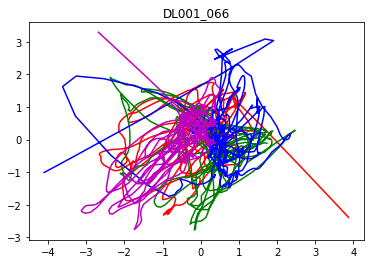

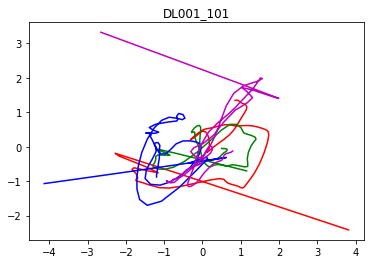

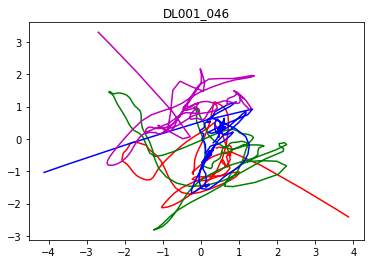

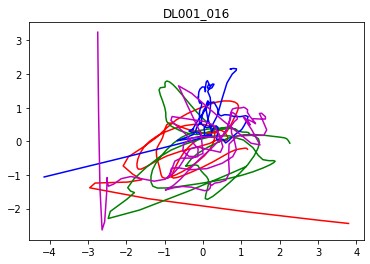

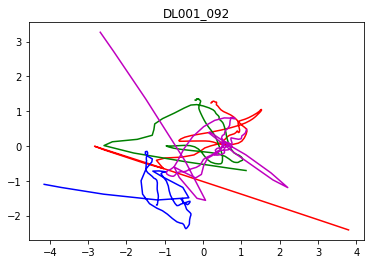

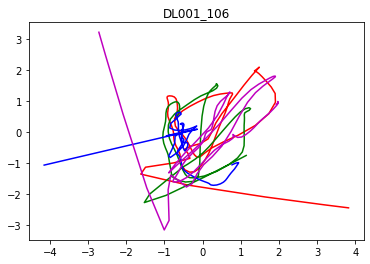

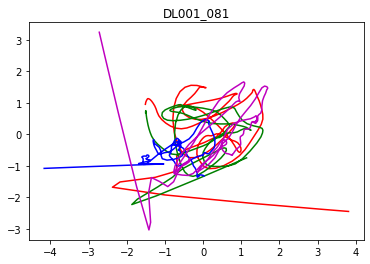

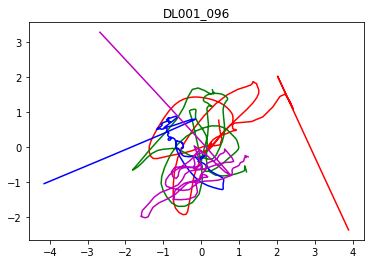

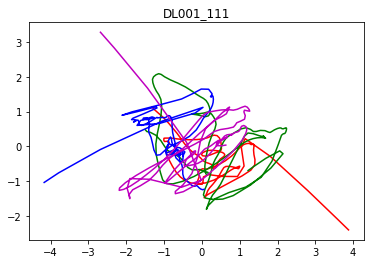

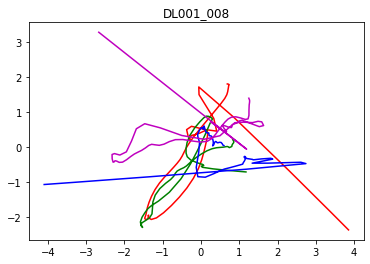

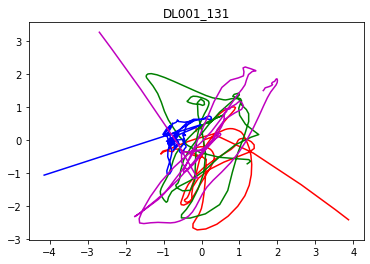

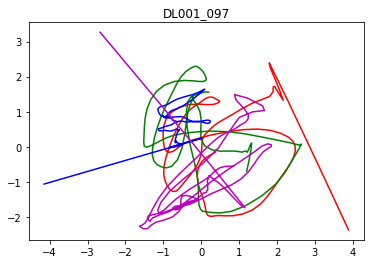

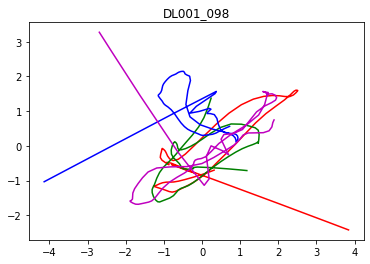

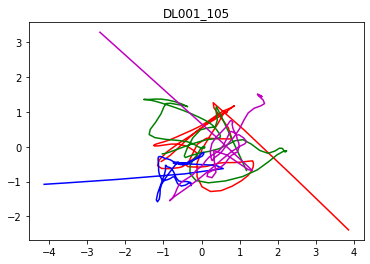

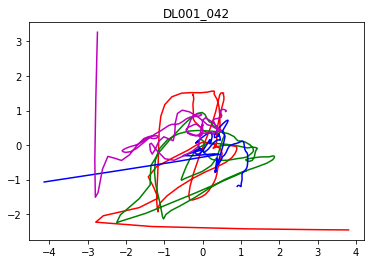

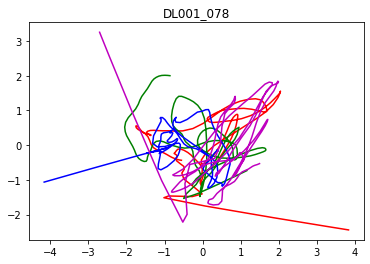

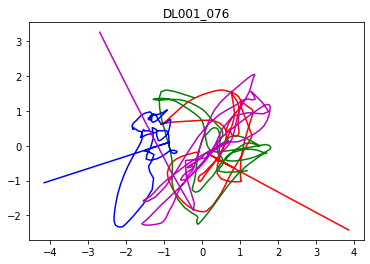

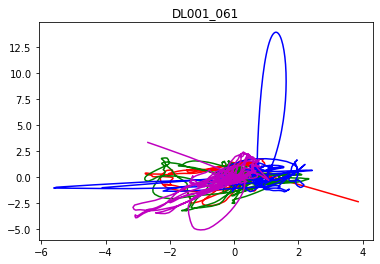

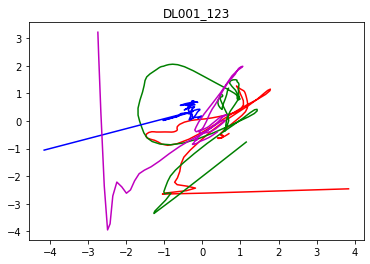

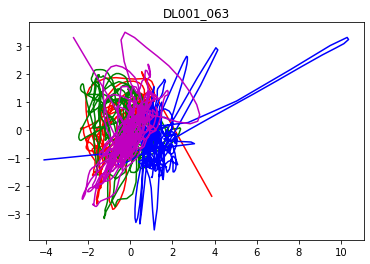

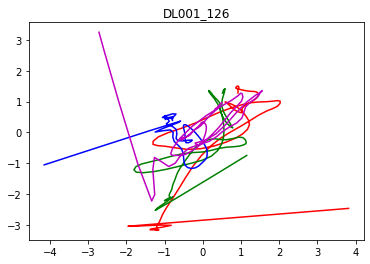

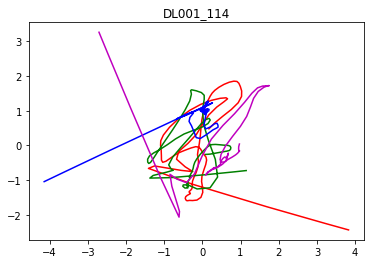

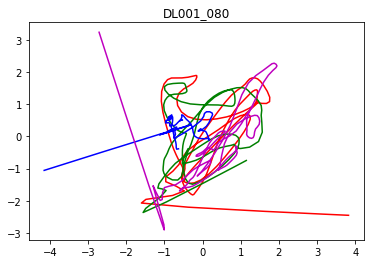

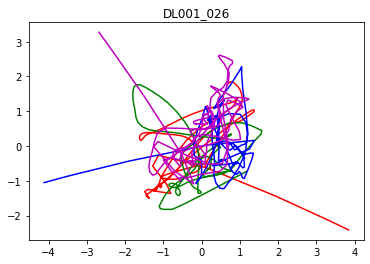

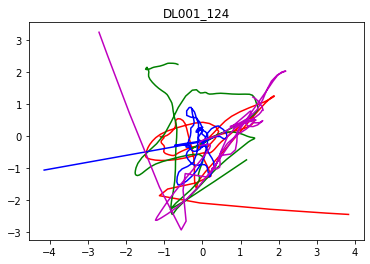

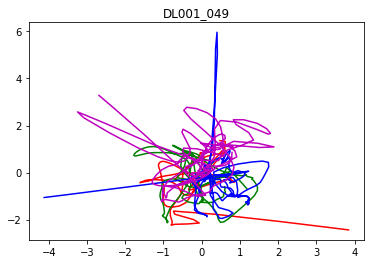

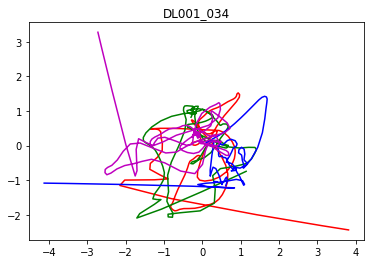

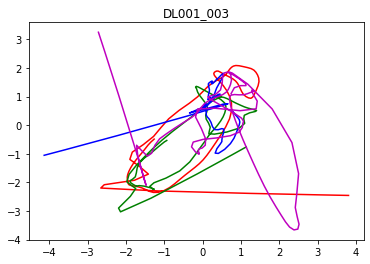

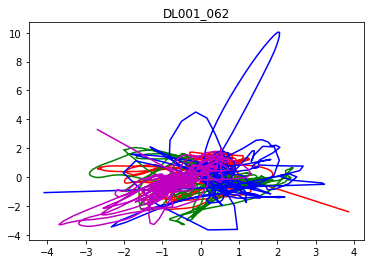

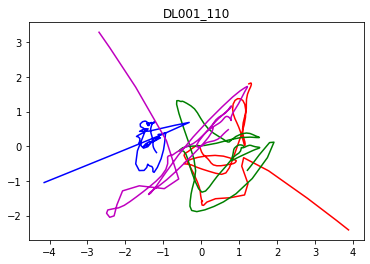

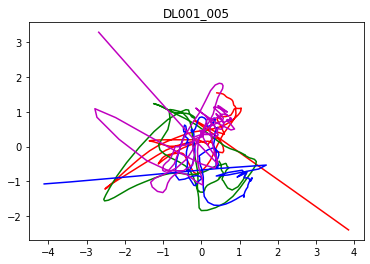

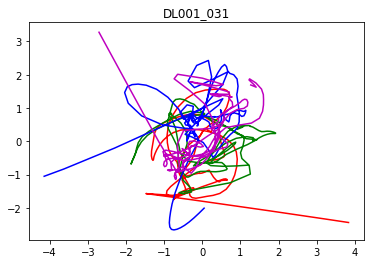

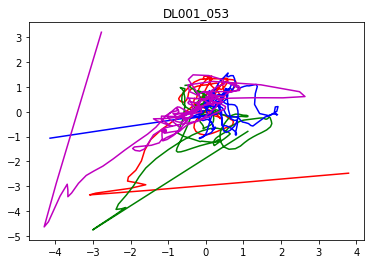

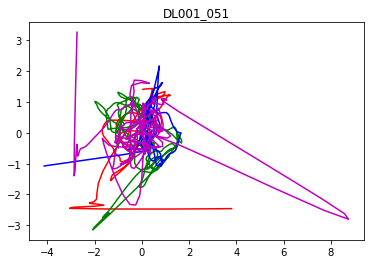

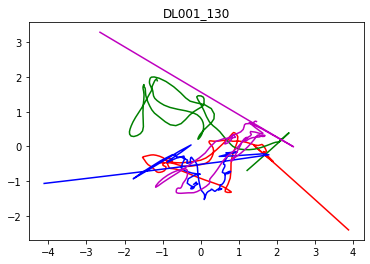

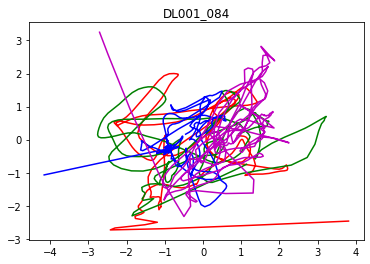

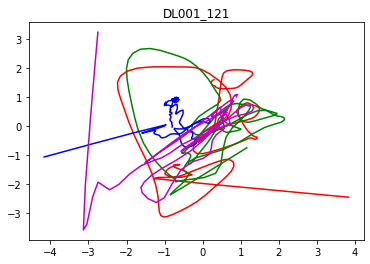

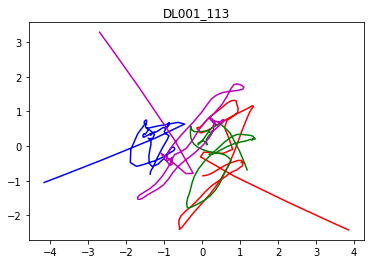

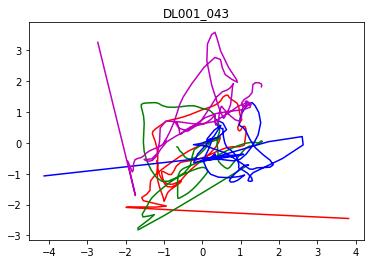

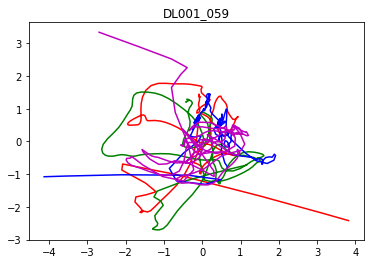

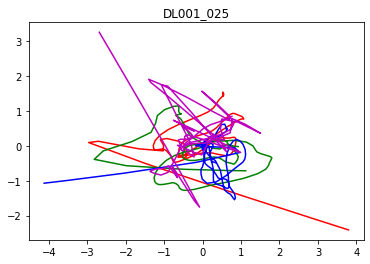

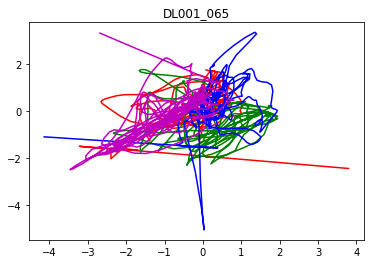

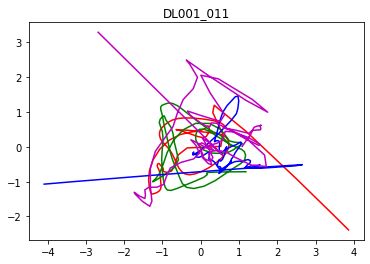

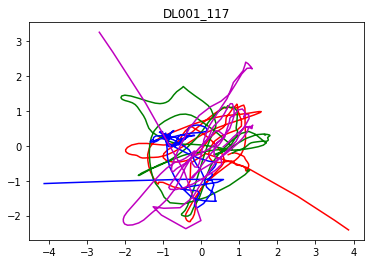

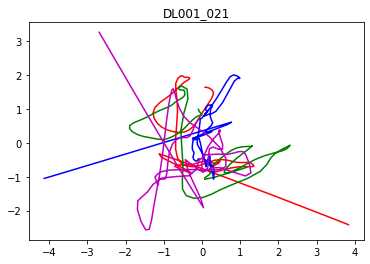

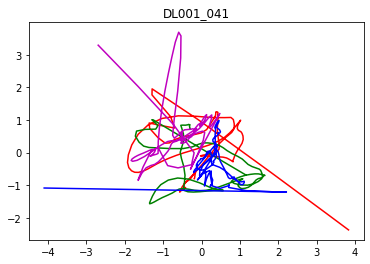

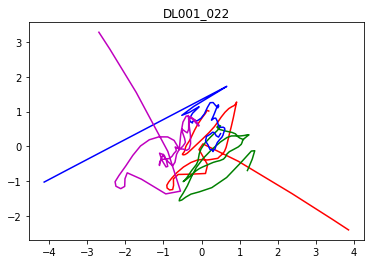

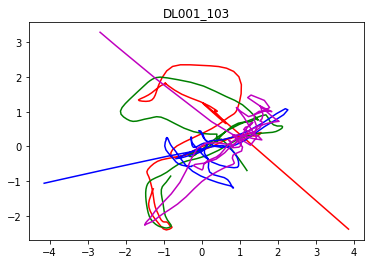

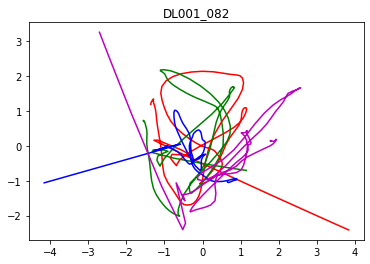

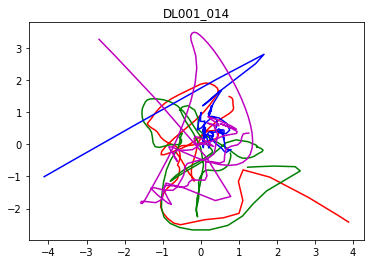

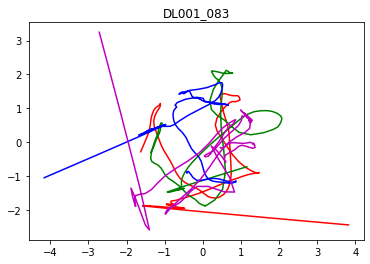

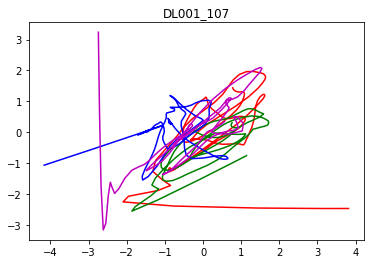

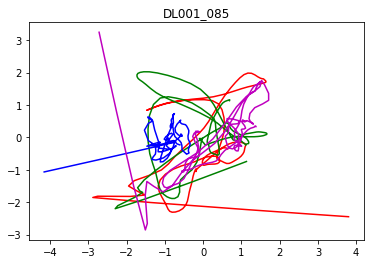

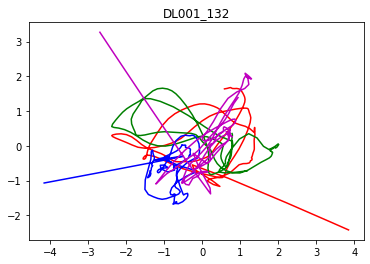

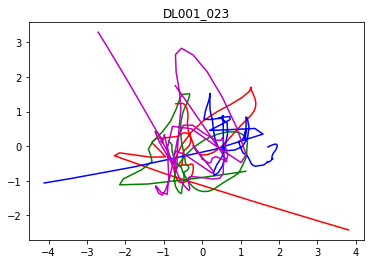

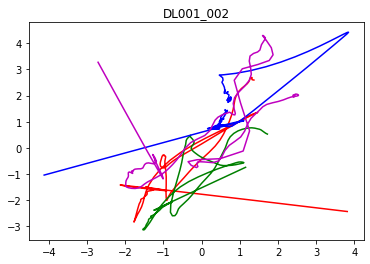

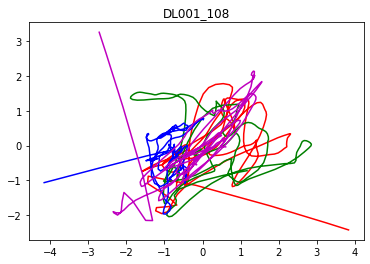

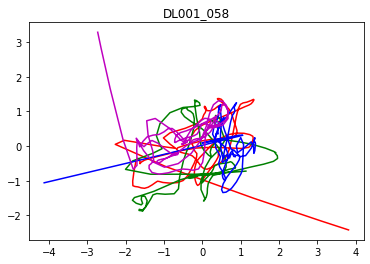

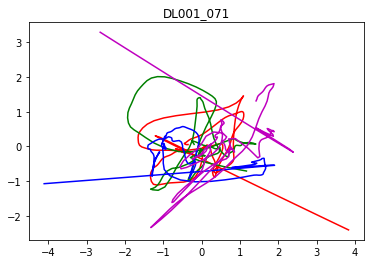

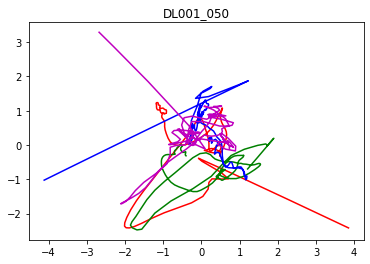

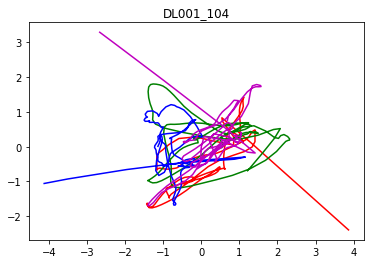

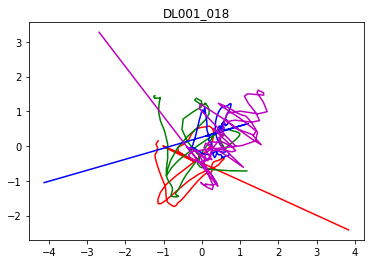

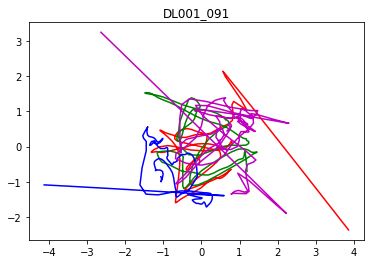

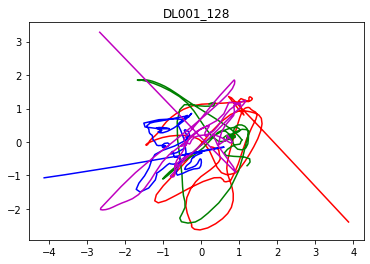

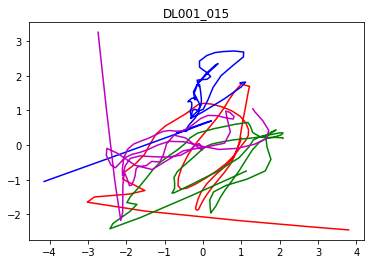

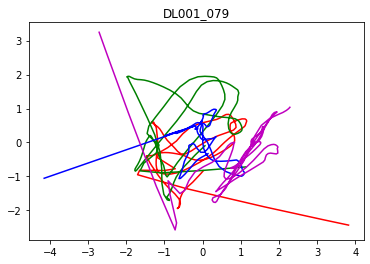

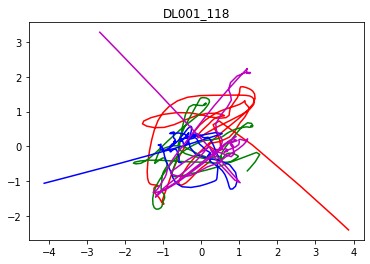

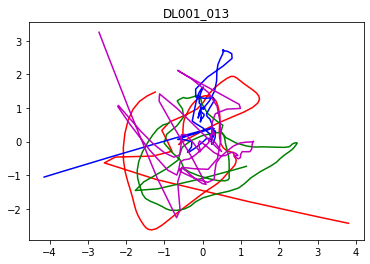

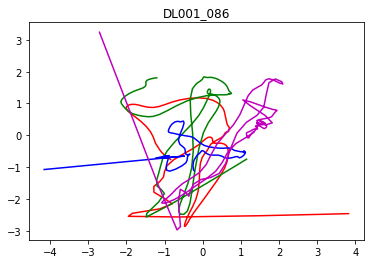

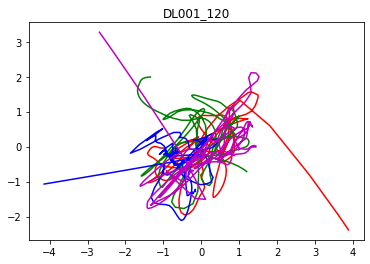

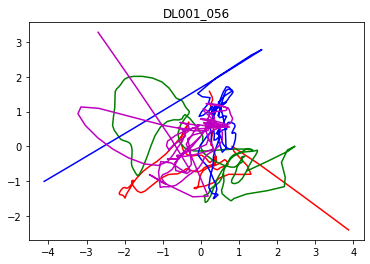

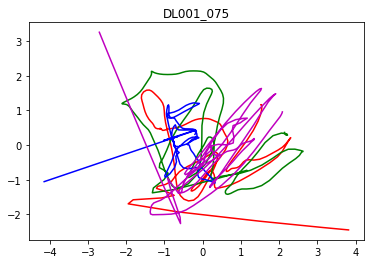

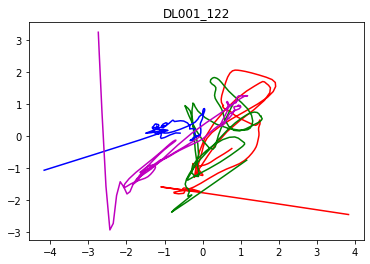

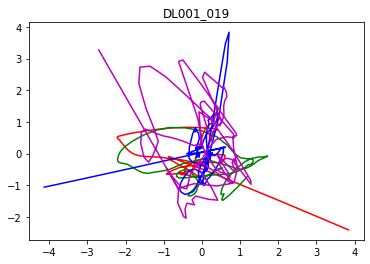

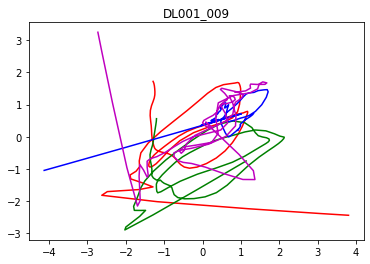

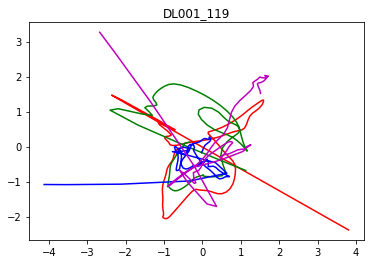

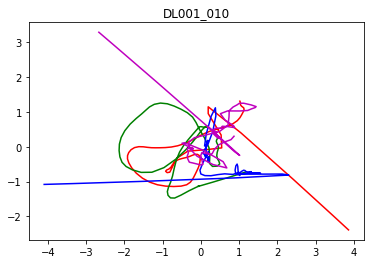

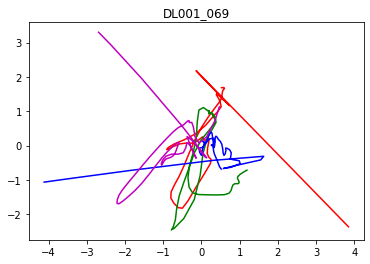

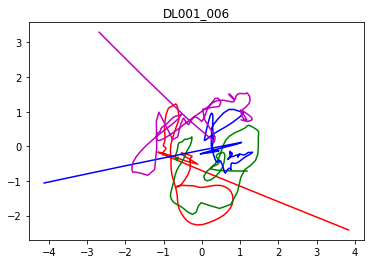

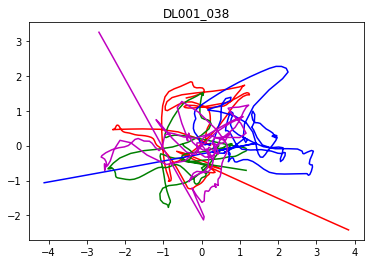

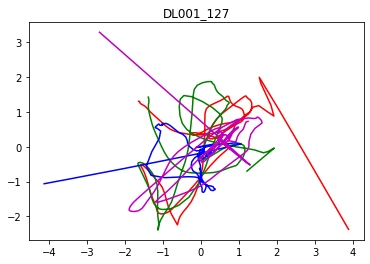

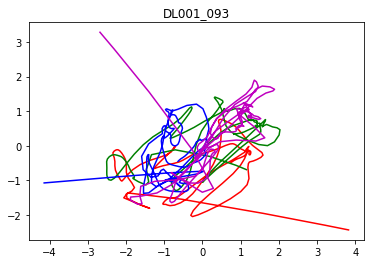

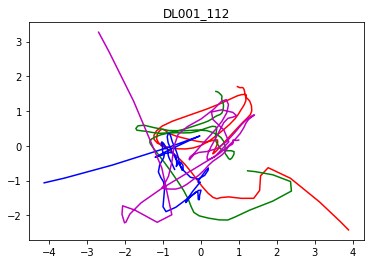

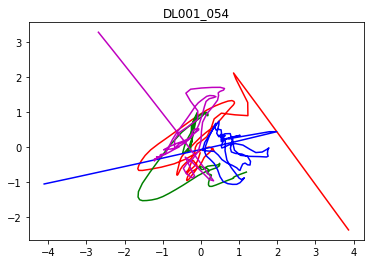

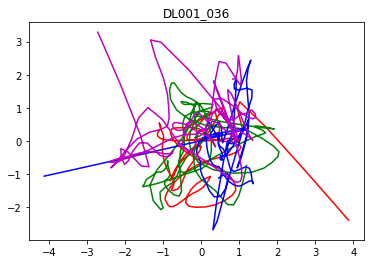

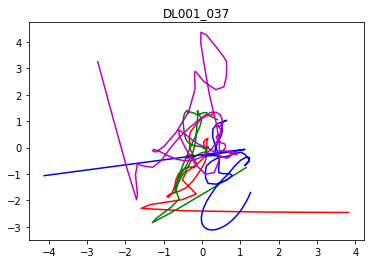

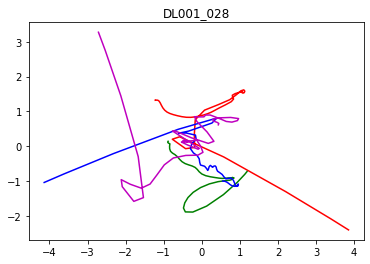

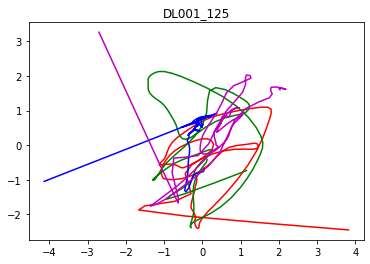

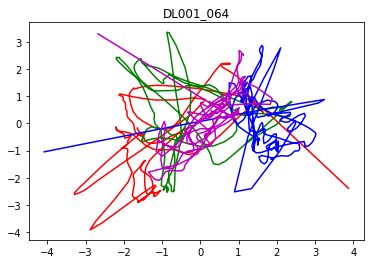

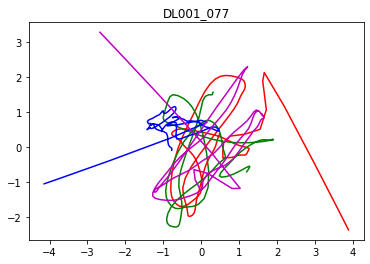

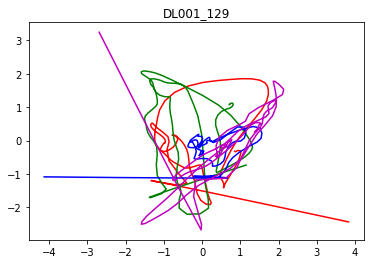

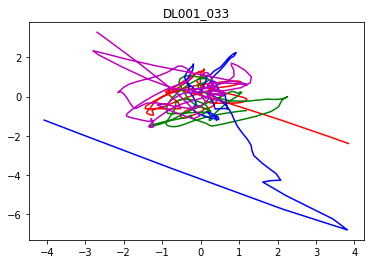

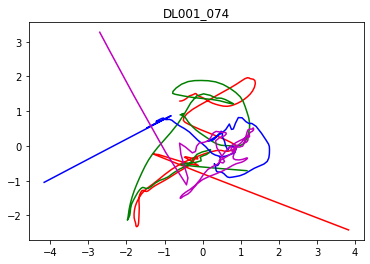

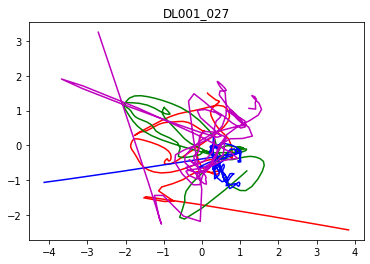

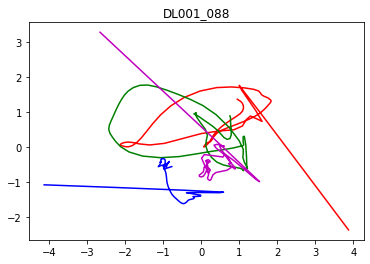

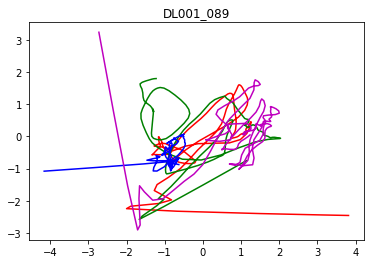

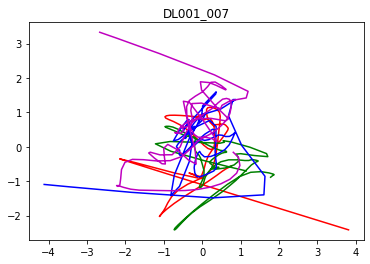

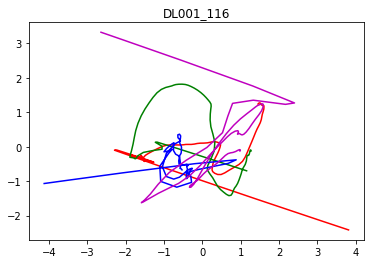

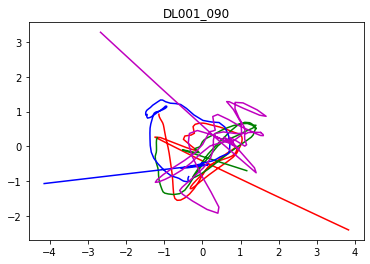

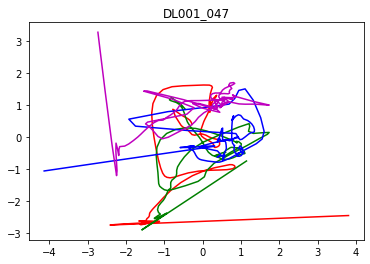

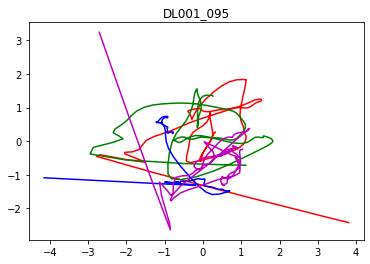

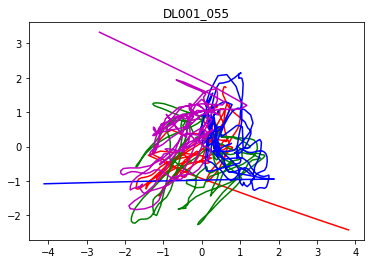

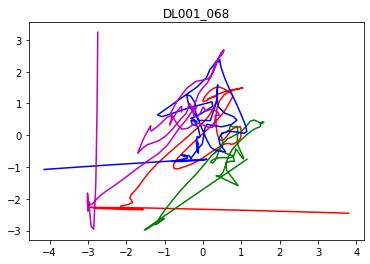

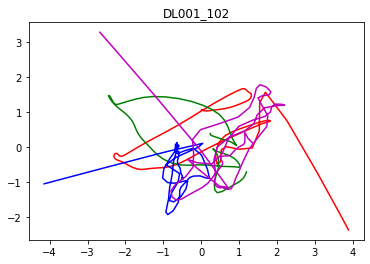

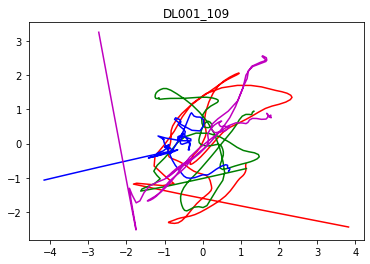

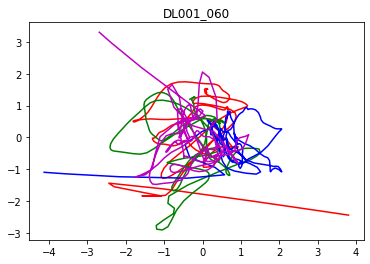

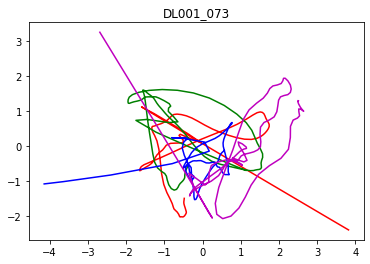

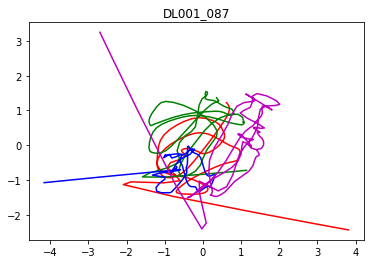

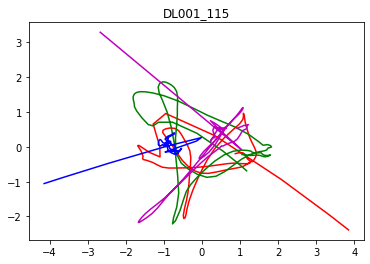

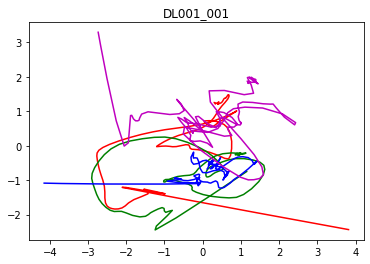

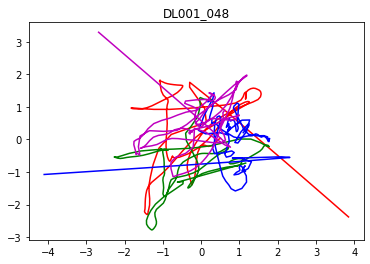

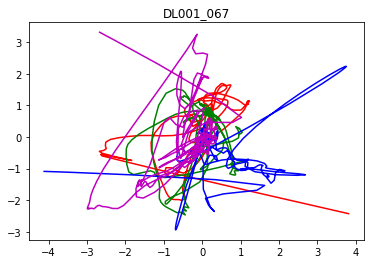

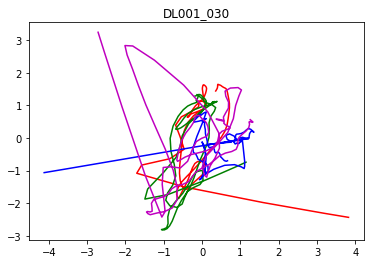

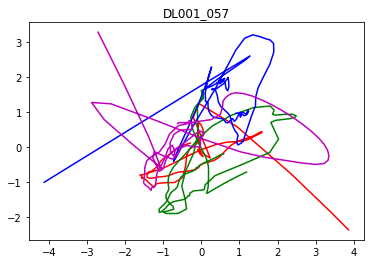

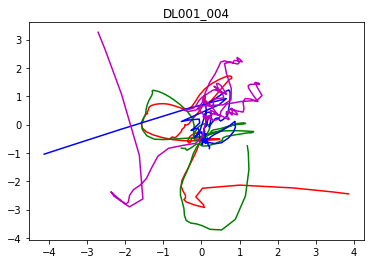

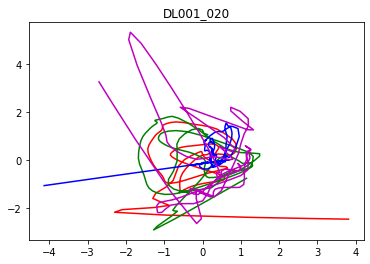

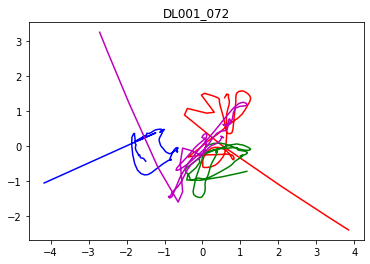

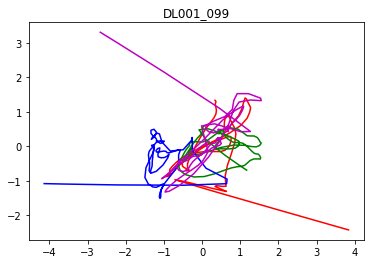

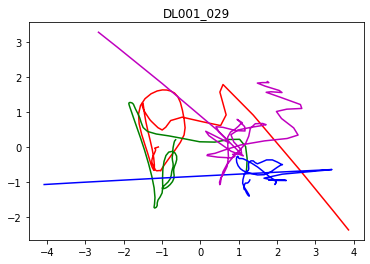

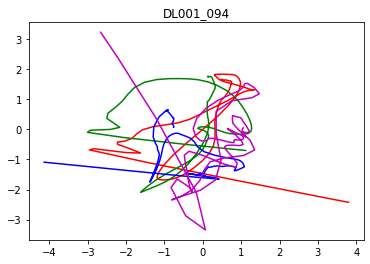

In [532]:
whole_dataset = Alaryngeal_data(data_path, file_id_list, transforms = None)

file_loader = torch.utils.data.DataLoader(dataset=whole_dataset,
                            batch_size=1,
                            shuffle=True,
                            collate_fn=lambda x: data_processing_DeepSpeech(x, transforms = train_transforms_all))

for batch_idx, _data in enumerate(file_loader):
    file_id, ema, labels, input_lengths, label_lengths = _data 
    MV = ema[0, 0]

    plt.figure()
    plt.title(file_id)
    plt.plot(MV[0,:], MV[1,:], 'r', MV[2,:], MV[3,:], 'g', MV[4,:], MV[5,:], 'b', 
             MV[6,:], MV[7,:], 'm')